# Supervised Learning: Classification

In this practical session you will learn how to use supervised learning methods to address important biomedical-related classification tasks.

In particular, we will use again the breast cancer Wisconsin (diagnostic) data set in order to train and evaluate a binary classification problem. Then, you will learn how to address a classification problem with ML methods when having more than two class labels.


### Agenda

0.	How to build a *dataframe* object.
1.  Learn how to evaluate and tune a classification model by using the KNN algorithm.
2.	Overfitting: a case study with the KNN algorithm. 
3.	Learning more about the trained classifier by using the *Confusion Matrix*.
4.  Evaluating the classification performances with cross-validation.
5.  Applying Logistic Regressions. 
6.  ROC curves.
7.  A multi-class classification problem.
8.  Applying Random Forests.
9.  Performance metrics for multi-class classification problems.

**Home/class work**

### *Recap of Breast Cancer Wisconsin data set*

We aim to use image-based features to learn how to classify a tumour as Benign (non-cancerous/harmless) or Malignant (cancerous/harmful). Image-based features (or attributes) are retrieved from biopsy images of breast tissues.

<img src="PS2/Img/breast_cancer_benign_vs_malign.png"/>

* **Tumour**: A tumour is an abnormal lump or growth of cells on a part of the body.
* **Benign Tumour**: A tumour that is not harmful and non-cancerous.
* **Malignant Tumour**: A tumour that is harmful and cancerous.

*Text and figure retrieved from https://medium.com/data-science-365/building-a-machine-learning-model-on-cancer-data-cd42c56721f4*

### *Prepare your toolbox and load the data*


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

The python module sklearn contains a number of data sets (not only related to biomedicine) that can be used to test ML algorithms.

The breast cancer data set is part of this bulk of data sets. The DESCR attribute of the dataset object contains a manually written description of the data. 

In [2]:
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()
print(cancer.DESCR)

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        worst/largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 0 is Mean Radi

The output from *load_breast_cancer* is as a *sklearn.utils.Bunch* object, but for convenience we will convert it into a *Pandas.DataFrame* in a moment. The *Bunch* is similar to a dictionary so we can check the component names using *keys()*.

In [3]:
print(cancer.keys())

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename'])


The cancer data are given as an *n-dimensional* array or, simply, a numerical matrix.

In [4]:
print(type(cancer))
print(type(cancer.data))
print(cancer.data.dtype)

<class 'sklearn.utils.Bunch'>
<class 'numpy.ndarray'>
float64


The ML algorithms in sklearn can work with both *Pandas* objects or *n-dimensional* arrays.

One of the main differences is that *n-dimensional* arrays cannot include variables/attributes/features of different data types (i.e. a mix of numerical and categorical variables).

In [5]:
print(type(cancer.target))
print(cancer.target.dtype)

<class 'numpy.ndarray'>
int32


If we want to put the data and target into the same table, we need to use a *DataFrame*.

## 0. How do we build a ```DataFrame``` object ?
We can create a ```DataFrame``` by calling it's constructor and passing to it a ```dict``` or ```ndarray``` containing the data. When using an ```ndarray``` we supply the column names separately. We can also insert new columns into the ```DataFrame``` via the selection method.

In [6]:
import pandas as pd 
data = pd.DataFrame(cancer.data, columns = cancer.feature_names)
data['target'] = cancer.target

**Recap**

In order to show the dataset dimensions ...

In [7]:
print("\n \t The data frame has {0[0]} rows and {0[1]} columns. \n".format(data.shape))


 	 The data frame has 569 rows and 31 columns. 



In order to show the first three rows ...

In [8]:
data.head(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0


Another important difference with built-in data set in *sklearn* is that the *diagnosis* variable is now called *target* and it is a binary variable.

In [9]:
data['target']

0      0
1      0
2      0
3      0
4      0
      ..
564    0
565    0
566    0
567    0
568    1
Name: target, Length: 569, dtype: int32

We will now show the number of 0 and 1 occurrences in the target variable.

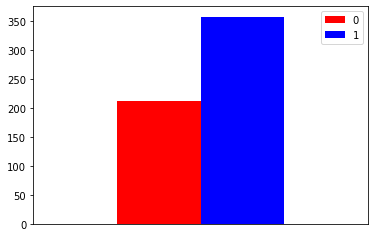

In [10]:
from collections import Counter

colors = ["red", "blue"]
class_counts = Counter(data['target'])
df = pd.DataFrame.from_dict(class_counts, orient='index')
bar_plot = df.T.plot(kind='bar', color=colors)
x_axis = bar_plot.axes.get_xaxis()
x_axis.set_visible(False)

## 1. Evaluate KNN-based classifiers

The k-nearest neighbors algorithm (k-NN) is a non-parametric, lazy learning method that can be used for both classification and regression. 

* *non-parametric* means that KNN does not make any assumption on the data distribution. 
* *lazy* means that KNN, differently from other ML methods, does not have an explicit learning step. The generalization of the training data is delayed until a query is made to the system. 

There are only 3 steps for KNN:
1. Calculate distance (e.g. Euclidean distance, Hamming distance, etc.)
2. Find the k closest neighbors
3. Vote for labels or calculate the mean

<img src="PS2/Img/knn.png"/>

*Figure from https://medium.com/30-days-of-machine-learning/day-3-k-nearest-neighbors-and-bias-variance-tradeoff-75f84d515bdb*


**Before applying the KNN algorithm, we need to pre-process our data**

### Data cleaning

No need to clean since the breast cancer data set loaded from *sklearn* does not have extra variables (e.g. *unnamed 32*)

In [11]:
features_mean = list(data.columns[0:9]) # Let's simplify our dataset
X = data.loc[:, features_mean] # With loc we can access columns and rows by name or boolean mask
y = data.loc[:,'target']

### Splitting data to training and testing sets

In [12]:
from sklearn.model_selection import train_test_split 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 54758) 

### Create and train a classifier

Let's start with the K-nearest neighbors algorithm

In [13]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors = 10) 
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=10)

### Calculate the prediction score

In [14]:
#classification accuracy of knn in classifiation of training and testing set
print('accuracy of knn n=10, on the training set: {:.3f}'.format(knn.score(X_train,y_train)))
print('accuracy of knn n=10, on the test set: {:.3f}'.format((knn.score(X_test,y_test))))

accuracy of knn n=10, on the training set: 0.892
accuracy of knn n=10, on the test set: 0.895


### Fine-tune KNN
In order to find the best number of neighbors, we could use the grid search implementation from *sklearn*, but here is a manual example:

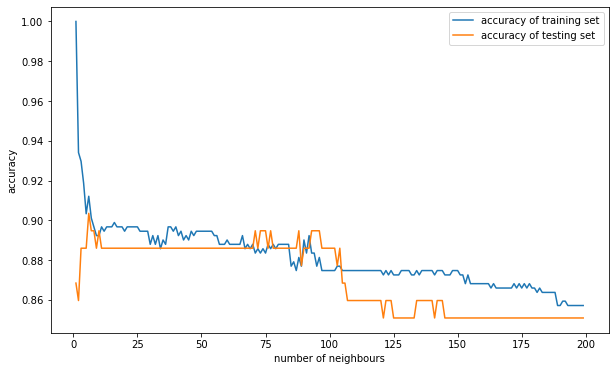

In [15]:
training_accuracy=[]
test_accuracy=[]

neighbors_settings = range(1,200)
for n_neighbors in neighbors_settings:
    clf = KNeighborsClassifier(n_neighbors=n_neighbors)
    clf.fit(X_train, y_train)
    training_accuracy.append(clf.score(X_train, y_train))
    test_accuracy.append(clf.score(X_test, y_test))

plt.figure(figsize = (10, 6))
plt.plot(neighbors_settings, training_accuracy, label='accuracy of training set')
plt.plot(neighbors_settings, test_accuracy, label='accuracy of testing set')
plt.ylabel('accuracy')
plt.xlabel('number of neighbours')    
plt.legend()

## 2. Overfitting: a case study with the KNN algorithm

### What is overfitting?

An important concept in ML is the bias-variance trade-off. 

The **bias** is an error from erroneous assumptions in the learning algorithm, while the **variance** is an error from sensitivity to small fluctuations in the training set. 
High variance can cause an algorithm to model the random noise in the training data, rather than the intended outputs. 
In other words, model with high variance pays a lot of attention to training data and fails to generalize on data which it hasn’t seen before.

#### Bias
* High bias can cause an algorithm to miss the relevant relations between features and target outputs.
* High bias usually applies to building simple models whose predictions do not reflect the reality of observed data but they are stable and don't change much from dataset to dataset.
* Low bias models make fewer assumptions.

#### Variance
* A model with high variance pays a lot of attention to training data and but makes mistakes when it comes to unseen data.


There are other two terms related to bias and variance, underfitting and overfitting. 

* **Underfitting** (= *high bias and low variance*) means the model is too restricted and does not predict the training data well. As a result the model may not learn anything useful and will perform poorly on new data. 

* **Overfitting** (= *low bias but high variance*) means that the model has high freedom and is able fit the training data too well. If new data is not very similar to previous data points, the predictions may be wrong. 

<img src="PS2/Img/tradeoff_bias_variance.png" width="700">

#### Find the right balance between bias and variance

* Overfitting and underfitting reduce total accuracy.
* Increasing the bias will usually lead to a decrease in variance. 
* Increasing the variance will usually lead to a decrease in bias.
* We have to find a nice balance of bias & variance.

<img src="PS2/Img/model_complexity.png" width="400">

### How do the bias and variance relate to KNN?

In order to address the *bias-variance* trade-off we need to understand how our chosen ML algorithm works.

We cannot treat it as black box.

Perhaps, we know that the core tuning parameter (aka *hyperparameter*) of the KNN algorithm is the number of neighbors -> **K**

Basically, **K** determines the complexity of our model. How? 

**IF K=1 THEN ?**

The model complexity is arguably minimized since we are using only the nearest neighbour. However, the bias is 0 (perfect accuracy on training data), but error rate on new data is high which causes high variance. 

**IF K>>1 THEN ?**

The training error (*1 - accuracy*) will increase (also increasing bias), but the test error may decrease at the same time (decreasing variance). However, the model's complexity increases as we use more neighbours.


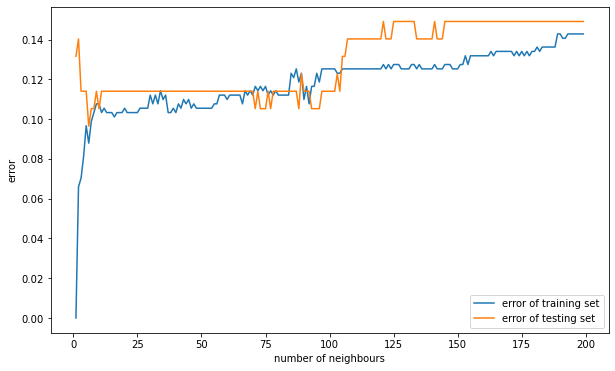

In [16]:
training_error=[]
test_error=[]

neighbors_settings = range(1,200)
for n_neighbors in neighbors_settings:
    clf = KNeighborsClassifier(n_neighbors=n_neighbors)
    clf.fit(X_train, y_train)
    training_error.append(1-clf.score(X_train, y_train))
    test_error.append(1-clf.score(X_test, y_test))
    
plt.figure(figsize = (10, 6))
plt.plot(neighbors_settings, training_error, label='error of training set')
plt.plot(neighbors_settings, test_error, label='error of testing set')
plt.ylabel('error')
plt.xlabel('number of neighbours')    
plt.legend()

#### What is the best value of K?

## 3. Learning more about the trained classifier by using the *Confusion Matrix*

#### Confusion matrix

The confusion matrix can be used to evaluate, in more detail, the quality of the output of a classifier.

#### How to build a confusion matrix

In [17]:
from sklearn.metrics import confusion_matrix

# create and train a KNN classifier
knn = KNeighborsClassifier(n_neighbors = 10) 
knn.fit(X_train, y_train)
# predict the class label for the 'unseen' test set
y_pred = knn.predict(X_test)
# build the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)
print(list(y_test).count(1))
print(list(y_test).count(0))

[[33 10]
 [ 2 69]]
71
43


The diagonal elements represent the number of points for which the predicted label is equal to the true label, while off-diagonal elements are those that are mislabeled by the classifier. The higher the diagonal values of the confusion matrix the better, indicating many correct predictions.

#### Important notes!

In a binary classification problem the two classes are often indicated as the Positive and the Negative class. Therefore, the diagonal elements represent True Positive and True Negative (respectively). 

The upper-right cell box indicates the False Positives, while the lower-left cell box represents the False Negatives.

The meaning of the positive and negative classes is up to us. We decide which class label correspond to positive or negative.  

A perfect classifier would have only true positives and true negatives, so its confusion matrix would have nonzero values only on its main diagonal (upper-left to lower-right):

#### How to plot the confusion matrix

The figures below show the confusion matrix with and without normalization by class support size (number of elements in each class).

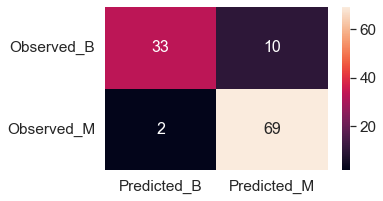

In [18]:
df_cm = pd.DataFrame(cm, range(2), range(2))
plt.figure(figsize = (5,3))
sns.set(font_scale = 1.4) # for label size
sns.heatmap(df_cm, annot = True, annot_kws = {"size": 16}, # font size
            yticklabels = ["Observed_B","Observed_M"], 
            xticklabels = ["Predicted_B","Predicted_M"]) 

plt.show()

Normalization may be useful in case of class imbalance in order to have a better interpretation about which class is being misclassified. To do that we divide by the count of each class in the true labels (observations). 

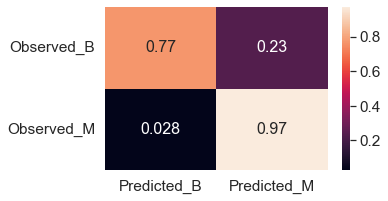

In [19]:
df_cm = pd.DataFrame(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], range(2), range(2))
plt.figure(figsize = (5,3))
sns.set(font_scale = 1.4) # for label size
sns.heatmap(df_cm, annot = True, annot_kws = {"size": 16},
            yticklabels = ["Observed_B","Observed_M"], 
            xticklabels = ["Predicted_B","Predicted_M"]) # font size

plt.show()

### Confusion matrix are instrumental when addressing imbalanced classification problems


(*From https://machinelearningmastery.com/precision-recall-and-f-measure-for-imbalanced-classification/*)

The confusion matrix provides more insight into not only the performance of a predictive model, but also which classes are being predicted correctly, which incorrectly, and what type of errors are being made.

The simplest confusion matrix is for a two-class classification problem, with negative (class 0) and positive (class 1) classes.

Starting from the CF we can compile alternative evaluation metrics:

* **Precision** quantifies the number of positive class predictions that actually belong to the positive class.
* **Recall** quantifies the number of positive class predictions with respect to all positive examples in the dataset.
* **F-Measure** provides a single score that balances both the concerns of precision and recall in one number.


#### Precision for binary classification

Precision is calculated as the number of true positives divided by the total number of true positives and false positives.

$Precision = \frac{\text{TruePositives}}{\text{TruePositives} + \text{FalsePositives}}$

The result is a value between 0.0 for no precision and 1.0 for full or perfect precision.

In [20]:
from sklearn.metrics import precision_score
precision = precision_score(y_test, y_pred, average='binary')
print('Precision: %.3f' % precision)

Precision: 0.873


#### Recall for binary classification

Recall is calculated as the number of true positives divided by the total number of true positives and false negatives.

$Recall = \frac{\text{TruePositives}}{\text{TruePositives} + \text{FalseNegatives}}$

The result is a value between 0.0 for no recall and 1.0 for full or perfect recall.

In [21]:
from sklearn.metrics import recall_score
recall = recall_score(y_test, y_pred, average='binary')
print('Recall: %.3f' % recall)

Recall: 0.972


#### Precision vs. Recall for Imbalanced Classification

You may decide to use precision or recall on your imbalanced classification problem.

Maximizing precision will minimize the number of false positives, whereas maximizing the recall will minimize the number of false negatives.

Precision is appropriate when minimizing false positives is the focus.  
Recall is appropriate when minimizing false negatives is the focus.  
Sometimes, we want excellent predictions of the positive class. We want high precision and high recall.

This can be challenging, as usually increasing recall comes at the expense of decreasing precision.

*— Page 55, Imbalanced Learning: Foundations, Algorithms, and Applications, 2013.*

#### F-Measure for binary classification

Provides a way to combine both precision and recall into a single measure that captures both properties.

$\textit{F-Measure} = \frac{2 \cdot \text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}$

… the F1-measure, which weights precision and recall equally, is the variant most often used when learning from imbalanced data.

*— Page 27, Imbalanced Learning: Foundations, Algorithms, and Applications, 2013.*

Like precision and recall, a poor F-Measure score is 0.0 and a best or perfect F-Measure score is 1.0.

In [22]:
from sklearn.metrics import f1_score
score = f1_score(y_test, y_pred, average='binary')
print('F-Measure: %.3f' % score)

F-Measure: 0.920


Further reading: https://machinelearningmastery.com/precision-recall-and-f-measure-for-imbalanced-classification/

<a id="section_4"></a>
## 4. Evaluating the classification performances with cross-validation
*K-fold cross-validation* can be used to obtain a more stable estimate of performance. 

Remember that K-fold cross-validation means splitting the training set into K-folds, 
then making predictions and evaluating them on each fold using a model trained on the remaining folds.

In the code below we use the *sklearn* cross validation implementation in our manual grid search for KNN.

In [23]:
neighbors = [] 
cv_scores = [] 
  
from sklearn.model_selection import cross_val_score 
# perform 10 fold cross validation 
for k in range(1, 100, 2): 
    neighbors.append(k) 
    knn = KNeighborsClassifier(n_neighbors = k) 
    scores = cross_val_score(knn, X_train, y_train, cv = 10, scoring = 'accuracy') 
    cv_scores.append(scores.mean()) 

The optimal number of neighbors is  11 


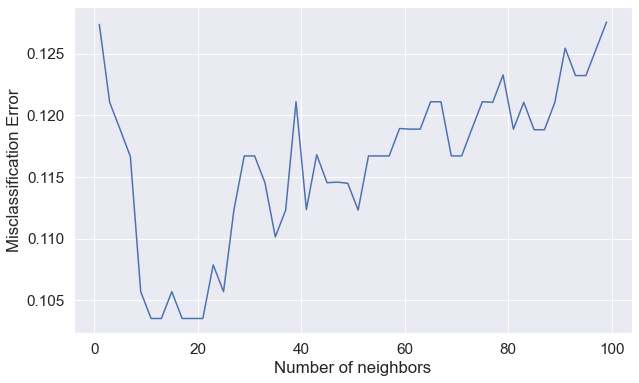

In [24]:
ERROR = [1-x for x in cv_scores] 
  
# determining the best k 
optimal_k = neighbors[np.argmin(ERROR)] 
print('The optimal number of neighbors is % d ' % optimal_k) 
  
# plot misclassification error versus k 
plt.figure(figsize = (10, 6)) 
plt.plot(neighbors, ERROR) 
plt.xlabel('Number of neighbors') 
plt.ylabel('Misclassification Error') 
plt.show() 

The result shows the number of neighbours that we can choose to get the highest cross-validation accuracy.

### Why is cross-validation more robust?

Cross-validation gives our model the opportunity to train on multiple train-test splits. 

This gives a better indication of how well our model will perform on unseen data. 

Hold-out, on the other hand, is dependent on just one train-test split.

### In applying the cross-validation for different K-values we did not use the whole dataset X, why?

Well, if we aim to tune hyper-parameters then splitting in training and test set is not enough!

We need to split the training set further into new (smaller) train and test set. In this case the test set is called validation set.

So, the training and validation sets are used to fine-tune the hyper-parameters and select the final model, which is evaluated on the independent test set. 

The most common strategy for the evaluation of ML algorithms is the following:
1. Use the hold-out strategy to define TRAINING and TEST sets.
2. Do the pre-processing steps (e.g. cleaning, imputation, scaling, etc.) on the TRAINING set.
3. Use k-fold cross-validation on the training set in order to fine-tune the ML algorithm.
4. The final model (with fixed hyper-parameters) is then trained on the TRAINING SET and tested on the independent TEST set.

<a id="section_5"></a>
## 5. Apply Logistic Regression

Before introducing the concept of decision threshold and then ROC curve, let's introduce a different type of classifier: logistic regression.

The logistic regression is commonly used to estimate the probability that an instance belongs to a particular class (e.g., what is the probability that this tumor sample is malignant?).

The main idea is to fit a linear model between a predictor and the target variable (linear regression) or multiple predictors and the target variable (multiple linear regression). Then, using the Sigmoid function (shown below) the standard linear formula is transformed to the logistic regression formula (also shown below). 

This logistic regression function is useful for predicting the class of a binary target feature.

For a simple example let's try to use a single feature to predict the *target* variable. Perhaps, we could use the *mean radius* to predict malignant tumor cells in breasts.

<AxesSubplot:xlabel='mean radius', ylabel='target'>

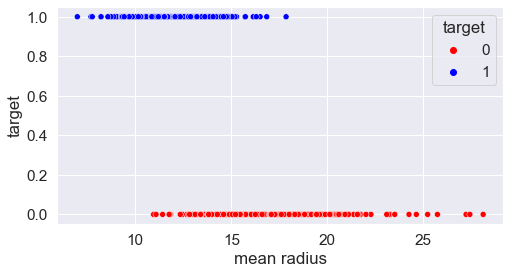

In [25]:
plt.figure(figsize=(8,4))
sns.scatterplot(x="mean radius", y="target", hue="target", data=data, palette = {0:'red', 1:'blue'})

It seems that this scenario is reasonable for logistic regression. 

So, let's use the ```sklearn``` module to build a Logistic Regression model based on *mean radius*.

In [26]:
from sklearn import linear_model
X_ra = X['mean radius'].values # take ndarray (1d)
X_ra = (X_ra).reshape(-1,1) # make a column vector (2d)
clf = linear_model.LogisticRegression(random_state = 0, solver = 'lbfgs', penalty = 'none', max_iter=100)
clf.fit(X_ra, y)

LogisticRegression(penalty='none', random_state=0)

After fitting the model, let's have a look at the estimated parameters: intercept and coefficient.

In [27]:
print(clf.intercept_)
print(clf.coef_)

[15.24527772]
[[-1.03354743]]


After fitting the linear model, the probability that an instance belongs to the positive class can be calculated by using the following formula.

\begin{equation*}
P(x) = \frac{1}{1+e^{-(\alpha +  \beta \cdot x)}},
\end{equation*}
where $\alpha$ is the intercept and $\beta$ is the coefficient.

With the following code, we visualize the *sigmoid* function that we estimated from the training data.

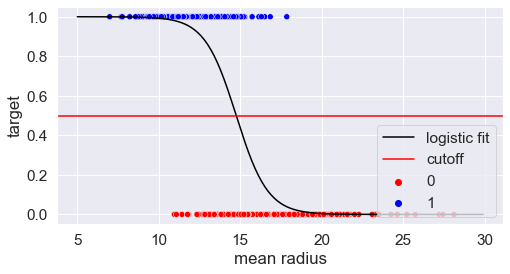

In [28]:
from scipy.special import expit
plt.figure(figsize=(8,4))
sns.scatterplot(x="mean radius", y="target", hue="target", data=data, palette = {0:'red', 1:'blue'})
X_plot = np.arange(5, 30, 0.1)
y_plot = X_plot * clf.coef_ + clf.intercept_
sigmoid = expit(y_plot) # expit === sigmoid
# ravel to convert the 2-d array to a flat array
plt.plot(X_plot, sigmoid.ravel(), c="black", label = "logistic fit")
plt.axhline(.5, color="red", label="cutoff")
plt.legend(loc="lower right")

#### But how do we assign a class label based on the class probability?

If the estimated probability is greater than 50%, then the model predicts that the instance belongs to the positive class, labeled “1”, or else it predicts that it does not (i.e., it belongs to the negative class, labeled “0”).

In general, it is more convenient start by predicting the probabilities of an observation belonging to each class (such that the probabilities sum to 1) in a classification problem rather than predicting the classes directly.

We can use the method ```predict_proba```, which returns the probability that a given observation has a particular label. 

#### Making predictions

Using the trained model, we can predict cancer malignancy for new *mean radius* values.

In [29]:
X_new = np.arange(5, 30, 0.5).reshape(-1, 1)
y_proba = clf.predict_proba(X_new)
print(y_proba[0])

[4.20108526e-05 9.99957989e-01]


#### Interpretation 

The ```predict_proba``` function returns an array with two values. 

The result of ```4.20108526e-05``` indicates the probability that the prediction is 0 (malignant) while the result of ```9.99957989e-01``` indicates the probability that the prediction is 1 (benign). Based on the default threshold of 0.5, the prediction is that the tumour is benign (value of 0), since its predicted probability is around 0.9, which is more than 0.5 (the threshold value). 

In [30]:
#other examples
print(y_proba[20])
print(y_proba[45])

[0.56412829 0.43587171]
[9.99998107e-01 1.89313094e-06]


The ```sklearn``` module provides alsto the function ```predict``` which returns the label with the highest probability.

In [31]:
y_label = clf.predict(X_new)
print(y_label[0])
print(y_label[20])
print(y_label[45])

1
0
0


#### What happens if we use a different threshold ?

In [32]:
y_label = (clf.predict_proba(X_new)[:,1] >= 0.4).astype(float) # set threshold as 0.4
print(y_label[0])
print(y_label[20])
print(y_label[45])

1.0
1.0
0.0


#### We can plot the estimated probabilities and observe the decision boundary.

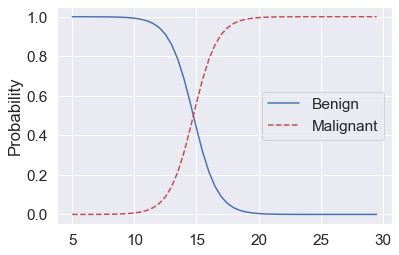

In [33]:
plt.plot(X_new, y_proba[:, 1], "b-", label="Benign")
plt.plot(X_new, y_proba[:, 0], "r--", label="Malignant")
plt.ylabel('Probability')
plt.legend(loc="right")

#### Using class probability instead of classes directly

We gain in flexibility! Probabilities may be interpreted using different thresholds (e.g. 50%, 60%, 30%, etc.) that allow the operator of the model to trade-off concerns in the errors made by the model, such as the number of false positives compared to the number of false negatives. 

This is required when using models where the cost of one error outweighs the cost of other types of errors.

Perhaps, for rare cancer data modeling, we should penalize false-negatives more. Then recall is a better measure than precision.

Two diagnostic tools that help in the interpretation of probabilistic forecast for binary (two-class) classification predictive modeling problems are **ROC Curves** and **Precision-Recall curves**.

## 6. ROC curves

A useful tool when predicting the probability of a binary outcome is the Receiver Operating Characteristic curve, or ROC curve.

ROC Curves summarize the trade-off between the *true positive rate* (times the model correctly predicts positive w.r.t. times it is really positive) and the *true negative rate* (times the model correctly predicts negative w.r.t. times it is really negative) for a predictive model using different probability thresholds.

Putting it in more practical terms, it is a plot of 1 - true negative rate (x-axis) versus the true positive rate (y-axis) for a number of different candidate threshold values between 0.0 and 1.0. 

ROC curves are appropriate when the observations are balanced between each class.

So, starting from the following formulas (*Lecture 2*)

$\textit{TruePositiveRate} = \frac{\text{TruePositives}}{\text{TruePositives} + \text{FalseNegatives}}$

We can notice that

$1 - TrueNegativeRate = 1 - \frac{\text{TrueNegatives}}{\text{FalsePositives} + \text{TrueNegatives}} =
\frac{\text{FalsePositives} + \text{TrueNegatives}}{\text{FalsePositives} + \text{TrueNegatives}} - \frac{\text{TrueNegatives}}{\text{FalsePositives} + \text{TrueNegatives}} =
\frac{\text{FalsePositives} + \text{TrueNegatives} - \text{TrueNegatives}}{\text{FalsePositives} + \text{TrueNegatives}} =
\frac{\text{FalsePositives}}{\text{FalsePositives} + \text{TrueNegatives}} =
FalsePositiveRate$, 

so on the x-axis we have

$\textit{FalsePositiveRate} = \frac{\text{FalsePositives}}{\text{FalsePositives} + \text{TrueNegatives}}$

The *true positive rate* is often referred as **Sensitivity**; wherase the *true negative rate* is often referred as **Specificity**.

First, we use the ```roc_curve``` function to create the true positive rate and false positive rate.

In [34]:
from sklearn.metrics import roc_curve, auc
 
probabilities = clf.predict_proba(X_ra)[:,1]
fpr, tpr, thresholds = roc_curve(y, probabilities)

Note! The ROC curve works on *scores*. So, we need to convert the class probabilities into scores. 
A simple solution is to use the positive class’s probability as the score.

#### Plot the ROC curve

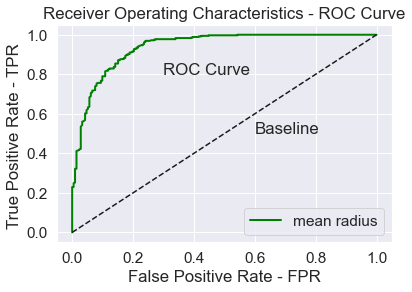

In [35]:
def plot_roc_curve(fpr, tpr, lab, col): 
    plt.plot(fpr, tpr, linewidth=2, label=lab, color=col) 
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal [...] # Add axis labels and grid
    plt.xlabel("False Positive Rate - FPR")
    plt.ylabel("True Positive Rate - TPR ")
    plt.title("Receiver Operating Characteristics - ROC Curve")
    plt.text(0.6,0.5,"Baseline")
    plt.text(0.3,0.8,"ROC Curve")
    plt.legend()

plot_roc_curve(fpr, tpr, lab = "mean radius", col = 'green')
plt.show()

The ROC curve will provide two important pieces of information:

* It summarizes the classification performances for different thresholds.
* The area under the curve (AUC) can be used as a summary of the model performance.

The dotted line represents the ROC curve of a purely random classifier; a good classifier stays as far away from that line as possible (toward the top-left corner).

In [36]:
# to compile the area under the curve (AUC)
from sklearn.metrics import roc_auc_score
roc_auc_score(y, probabilities) 

0.9375165160403786

#### What if we use more than one predictors

The Logistic Regression-based model relies on one single feature: *mean radius*.

Let's now fit a model based on all features.

In [37]:
log_reg = linear_model.LogisticRegression(random_state = 0, solver = 'lbfgs', max_iter=1000)
log_reg.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=0)

In [38]:
from sklearn.metrics import roc_curve, auc
 
probabilities2 = log_reg.predict_proba(X_test)[:,1]
fpr2, tpr2, thresholds2 = roc_curve(y_test, probabilities2)

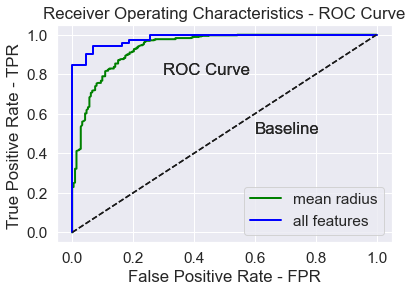

In [39]:
plot_roc_curve(fpr, tpr, lab = "mean radius", col = 'green')
plot_roc_curve(fpr2, tpr2, lab = "all features", col = 'blue')
plt.show()

In [40]:
# to compile the area under the curve (AUC)
roc_auc_score(y_test, probabilities2) 

0.9823124795283328

<a id="section_7"></a>
## 7. A multi-class classification problem

Whereas binary classifiers distinguish between two classes, multiclass classifiers (also called multinomial classifiers) can distinguish between more than two classes.

Some algorithms (such as Random Forest classifiers or naive Bayes classifiers) are capable of handling multiple classes directly. 

Others (such as Support Vector Machine classifiers or Linear classifiers) are strictly binary classifiers. However, there are various strategies that you can use to perform multiclass classification using multiple binary classifiers.

Let's use a different dataset with multiple labels. 

In [41]:
import os
print(os.getcwd())

C:\Users\lucacat\JupyterProjects\MOA1


In [42]:
mcdata = pd.read_csv('PS2/acd_icd.csv')

This data contains gene expression values from skin biopsies after exposure to allergens or irritants. The samples are classified to allergic contact dermatitis (ACD), irritant contact dermatitis (ICD) and baseline. 

Contact dermatitis is an inflammatory skin disorder that arises from direct skin-contact with irritants or allergens.

Let's see if we can classify the samples based on gene expression.

### Explore the data and understand the problem

In [43]:
mcdata.head()

,Unnamed: 0,KRT78,IL36G,IGFL3,FABP5P10,ELOVL4,BASP1P1,SLPI,LINC02265,METTL7A,...,NFE2,CD69,HSPA6,GZMA,CYP4Z1,CYP4Z2P,BATF3,WFDC12,IL3,target
0,503_02,8.717422,7.489652,6.427310,8.126517,9.278866,7.671808,12.602219,9.035972,12.547458,...,9.726118,9.392248,8.458895,11.250186,6.359751,7.100394,10.602697,8.380394,7.885223,ACD
1,503_04,11.604632,11.967928,8.606189,10.014981,10.469401,9.330587,13.292876,10.258511,13.135249,...,9.485372,8.543203,8.636146,10.418808,6.283220,6.252025,9.399967,6.596559,5.935807,ICD
2,506_02,9.055756,7.570949,7.866717,8.727117,9.927483,8.374692,11.634753,9.514567,12.488569,...,9.797251,9.306575,10.988169,11.518547,7.392881,7.589736,10.963952,9.152626,8.694906,ACD
3,506_04,11.759529,11.102866,9.803288,11.422439,11.335449,10.779302,13.503472,11.536517,12.840525,...,8.271026,6.963408,7.791604,8.516477,6.308749,6.483884,8.043559,7.139791,5.878294,ICD
4,507_04,12.269350,10.507343,10.541989,10.119876,11.799865,10.066427,12.907445,11.042282,13.491190,...,7.892962,6.840436,7.995431,8.829918,6.229646,6.011716,8.847925,6.649096,7.063472,ICD


In [44]:
mcdata.values.shape

(90, 137)

In [45]:
mcdata.describe()

,KRT78,IL36G,IGFL3,FABP5P10,ELOVL4,BASP1P1,SLPI,LINC02265,METTL7A,RDH12,...,IL4,NFE2,CD69,HSPA6,GZMA,CYP4Z1,CYP4Z2P,BATF3,WFDC12,IL3
count,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,...,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000
mean,10.676883,9.437904,8.607360,9.861178,10.510057,9.191039,12.670976,10.362898,12.822451,11.629712,...,6.842903,9.203779,8.557178,8.650654,10.110351,7.156030,7.256973,9.855497,8.609687,6.945091
std,1.465258,1.435925,1.547579,1.051832,1.053487,1.040498,1.075708,0.881078,0.906830,0.927226,...,1.109282,0.999121,1.443412,0.714527,1.400818,1.314343,1.353425,1.587930,1.382722,1.477945
min,7.739094,7.103261,5.644011,7.931941,8.174800,7.211974,10.551331,8.731490,10.340024,9.285288,...,5.696848,7.176281,6.422016,7.513891,7.668553,5.755480,5.919266,7.291418,5.985699,5.490905
25%,9.534380,8.341415,7.233092,9.073871,9.825890,8.357320,11.856327,9.523375,12.307535,10.954225,...,5.948025,8.292014,7.370409,8.131097,9.049005,6.266071,6.291330,8.574823,7.434015,5.892604
50%,10.574353,8.999541,8.952420,9.761571,10.792760,8.969142,12.762175,10.268256,13.030903,11.789248,...,6.369735,9.436993,8.486112,8.524234,9.749407,6.535291,6.606272,9.294475,8.702748,6.314641
75%,11.870063,10.417390,9.793858,10.760739,11.427267,10.126381,13.345625,11.140352,13.594141,12.367634,...,7.586232,10.074167,9.642599,9.026295,11.627031,7.764364,7.825937,11.325162,9.810692,7.841373
max,13.581094,13.747203,11.325452,12.186122,12.269015,11.483758,15.129527,12.154899,14.129462,13.165878,...,10.296669,11.356615,11.820679,11.431087,12.570211,11.066901,11.191665,13.131304,12.328798,12.241223


Print class distribution:

In [46]:
##class distribution
diagnosis_all = list(mcdata.shape)[0]
diagnosis_categories = mcdata['target'].value_counts() # yields a pandas.Series
output_str = "\n \t The data has {} diagnoses".format(diagnosis_all)
for count, diag in zip(diagnosis_categories, diagnosis_categories.index): # index contains the names of each entry in the Series
    output_str += ", {} {} diagnosis".format(count, diag)
print(output_str + '.')


 	 The data has 90 diagnoses, 42 ICD diagnosis, 34 ACD diagnosis, 14 BASELINE diagnosis.


Pie chart example with matplotlib:

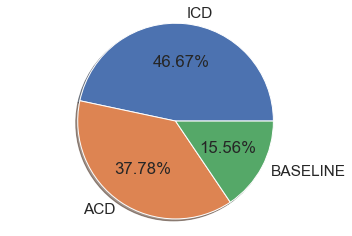

In [47]:
labels = ['ICD','ACD','BASELINE']
sizes = mcdata['target'].value_counts()
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.2f%%', shadow=True)
ax1.axis('equal')
plt.show()

### Data preparation

In [48]:
print(mcdata.columns[0])

Unnamed: 0


In [49]:
mcdata.drop(mcdata.columns[0], axis=1, inplace=True)

In [50]:
mcdata.head()

,KRT78,IL36G,IGFL3,FABP5P10,ELOVL4,BASP1P1,SLPI,LINC02265,METTL7A,RDH12,...,NFE2,CD69,HSPA6,GZMA,CYP4Z1,CYP4Z2P,BATF3,WFDC12,IL3,target
0,8.717422,7.489652,6.427310,8.126517,9.278866,7.671808,12.602219,9.035972,12.547458,10.412152,...,9.726118,9.392248,8.458895,11.250186,6.359751,7.100394,10.602697,8.380394,7.885223,ACD
1,11.604632,11.967928,8.606189,10.014981,10.469401,9.330587,13.292876,10.258511,13.135249,12.085846,...,9.485372,8.543203,8.636146,10.418808,6.283220,6.252025,9.399967,6.596559,5.935807,ICD
2,9.055756,7.570949,7.866717,8.727117,9.927483,8.374692,11.634753,9.514567,12.488569,10.896364,...,9.797251,9.306575,10.988169,11.518547,7.392881,7.589736,10.963952,9.152626,8.694906,ACD
3,11.759529,11.102866,9.803288,11.422439,11.335449,10.779302,13.503472,11.536517,12.840525,12.598897,...,8.271026,6.963408,7.791604,8.516477,6.308749,6.483884,8.043559,7.139791,5.878294,ICD
4,12.269350,10.507343,10.541989,10.119876,11.799865,10.066427,12.907445,11.042282,13.491190,12.755536,...,7.892962,6.840436,7.995431,8.829918,6.229646,6.011716,8.847925,6.649096,7.063472,ICD


Encode the class labels

In [51]:
mcdata.loc[mcdata.target == 'ICD', 'target'] = 0
mcdata.loc[mcdata.target == 'ACD', 'target'] = 1
mcdata.loc[mcdata.target == 'BASELINE', 'target'] = 2

In [52]:
mcdata.loc[:,'target']

0     1
1     0
2     1
3     0
4     0
     ..
85    0
86    1
87    0
88    1
89    0
Name: target, Length: 90, dtype: object

In [53]:
selected_genes = ['BATF','KRT78']

Let's select just two predictors or genes.

*Note!* Pre-selecting genes/features (or predictors) is usually something that you do not want to do. Because you do not want take the risk of discarding informative predictors. Here, we pre-select two features (genes) for simplicity. 

So, we now aim to use the gene expression profile of two genes in order to learn how to classify samples into ACD, ICD or BASELINE. 

For two features we can conveniently plot the classes with a scatterplot.

<AxesSubplot:xlabel='BATF', ylabel='KRT78'>

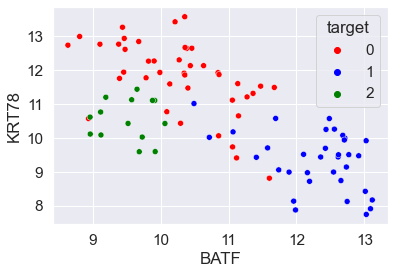

In [54]:
sns.scatterplot(x="BATF", y="KRT78", hue="target", data=mcdata, palette = {0:'red', 1:'blue', 2:'green'})

### Splitting in training and test set

In [55]:
from sklearn.model_selection import train_test_split

Xd = mcdata.loc[:, selected_genes]  #Xd = mcdata.loc[:, mcdata.columns != 'target'] 
yd = mcdata.loc[:,'target']
Xd_train, Xd_test, yd_train, yd_test = train_test_split(Xd.to_numpy(), yd.to_numpy(), test_size = 0.3, random_state = 42) 

## 8. Apply Random Forest-based classifiers

### Decision trees

Random forests are an example of an ensemble learner built on decision trees. 

So let's first discuss about decision trees.

Decision trees are extremely intuitive ways to classify or label objects: you simply ask a series of questions designed to zero-in on the classification. 

Below there is an example of a decision tree aiming at using two genes to group patient samples in *cancer* and *no-cancer*. 

<img src="PS2/Img/RF.png" width="700">

An important hyper-parameter of a decision tree is the "depth".

A larger depth corresponds to a greater complexity. 

### How do we classify a new point?

We classify a new point simply by moving down the tree, using the features/genes of the point to answer the questions until we arrive at a leaf node where the classes are assigned. 

A decision tree can naturally handle binary or multiclass classification problems.

Let's use decision trees with different depths.

In [56]:
from sklearn.tree import DecisionTreeClassifier
from itertools import product

# Training classifiers
clf1 = DecisionTreeClassifier(max_depth=1)
clf2 = DecisionTreeClassifier(max_depth=2)
clf3 = DecisionTreeClassifier(max_depth=3)
clf4 = DecisionTreeClassifier(max_depth=4)

clf1.fit(Xd_train, yd_train.astype(int));
clf2.fit(Xd_train, yd_train.astype(int));
clf3.fit(Xd_train, yd_train.astype(int));
clf4.fit(Xd_train, yd_train.astype(int));

For small trees we can visualize them like this:

In [57]:
from sklearn import tree
text_representation = tree.export_text(clf2, feature_names = selected_genes)
print(text_representation)

|--- BATF <= 11.68
|   |--- KRT78 <= 11.46
|   |   |--- class: 2
|   |--- KRT78 >  11.46
|   |   |--- class: 0
|--- BATF >  11.68
|   |--- class: 1



In [58]:
text_representation = tree.export_text(clf3, feature_names = selected_genes)
print(text_representation)

|--- BATF <= 11.68
|   |--- KRT78 <= 11.46
|   |   |--- BATF <= 10.00
|   |   |   |--- class: 2
|   |   |--- BATF >  10.00
|   |   |   |--- class: 0
|   |--- KRT78 >  11.46
|   |   |--- class: 0
|--- BATF >  11.68
|   |--- class: 1



### Visualize the trained decision trees

Note: the arrows might be missing due to a 'conflict' between seaborn and scikit-learn. It should be fixable in scikit-learn 0.24.0 by using a non-white seaborn theme.

To read the trees check the condition of the root node, move left if condition is true and move right otherwise.

**Fitted DT with depth = 1**

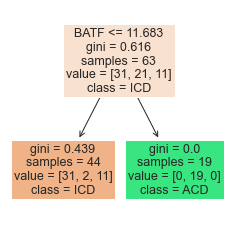

In [59]:
from sklearn import tree
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (4,4))
tree.plot_tree(clf1, 
               feature_names = selected_genes, 
               class_names = ['ICD','ACD','BASELINE'],
               filled = True);

plt.show()

**Fitted DT with depth = 2**

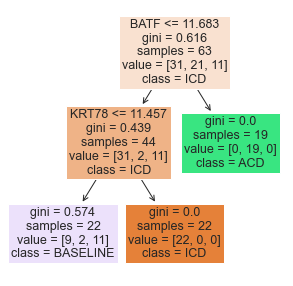

In [60]:
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (5,5))
tree.plot_tree(clf2, 
               feature_names = selected_genes, 
               class_names = ['ICD','ACD','BASELINE'],
               filled = True);

**Fitted DT with depth = 3**

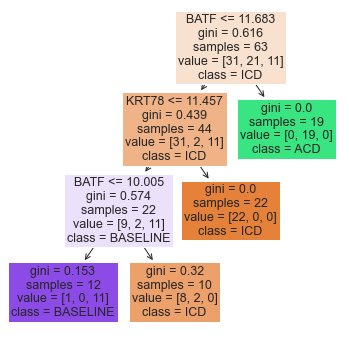

In [61]:
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (6,6))
tree.plot_tree(clf3, 
               feature_names = selected_genes, 
               class_names = ['ICD','ACD','BASELINE'],
               filled = True);

**Fitted DT with depth = 4**

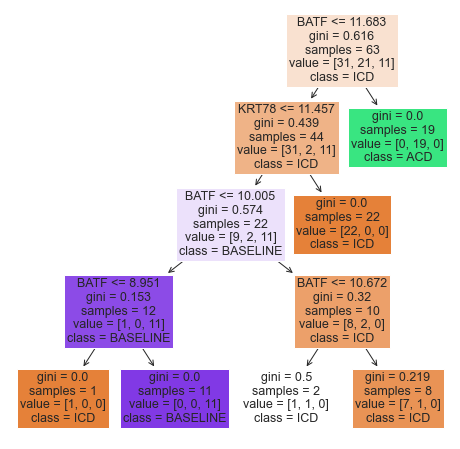

In [62]:
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (8,8))

tree.plot_tree(clf4, 
               feature_names = selected_genes, 
               class_names = ['ICD','ACD','BASELINE'],
               filled = True);

**Plotting decision regions**

When we don't have too many features we can plot decision regions for the trees.

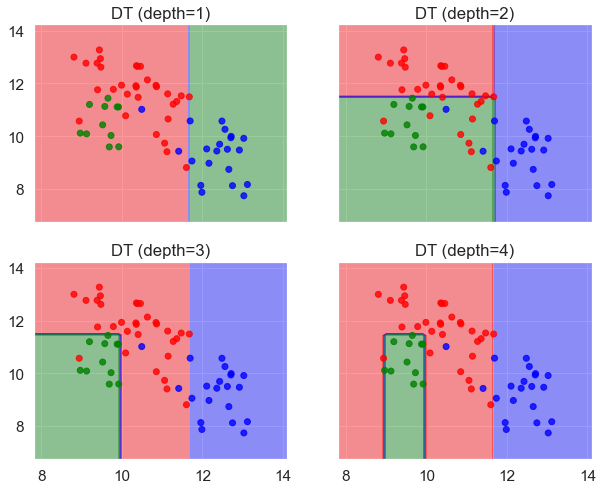

In [63]:
x_min, x_max = Xd_train[:, 0].min() - 1, Xd_train[:, 0].max() + 1
y_min, y_max = Xd_train[:, 1].min() - 1, Xd_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['red','blue','green'])

f, axarr = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(10, 8))

for idx, clf, tt in zip(product([0, 1], [0, 1]),
                        [clf1, clf2, clf3, clf4],
                        ['DT (depth=1)', 'DT (depth=2)',
                         'DT (depth=3)', 'DT (depth=4)']):

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.4, cmap=custom_cmap) # cmap="RdBu_r")
    axarr[idx[0], idx[1]].scatter(Xd_train[:, 0], Xd_train[:, 1], 
                                  c = yd_train, cmap=custom_cmap,
                                  alpha=0.8)
    axarr[idx[0], idx[1]].set_title(tt)

plt.show()

**Which are the most underfitting/overfitting models?**

Decision trees are quite sensitive to noisy data.

A decision tree is prone to overfitting because it has unlimited flexibility, meaning that it can keep growing until it has exactly one leaf node for every single observation, perfectly classifying all of them.

The problem is that the model learns not only the actual relationships in the training data, but also any noise that is present.

Of course, we can limit the maximum depth to 2 or 3, but then the classifications are no longer 100% correct. Perhaps, by aiming at limiting the depth of a decision tree so that it can generalize better on new unseen data, there is the risk to still miss some important patterns (see the DT2).

We have reduced the variance of the decision tree but at the cost of increasing the bias.

Putting it in practical terms, addressing the bias-variance trade-off with decision trees is very complicated.

Limiting the depth of the tree reduces variance (good) and increases bias (bad). 
An alternative startegy is to combine many decision trees into a single ensemble model known as the random forest.

### Random Forest

The random forest is a model made up of many decision trees.

Rather than just simply averaging the prediction of trees (which we could call a “forest”), this model uses two key concepts that gives it the name random:
* Random sampling of training data points when building trees
* Random subsets of features considered when splitting nodes

**Random sampling of training observations**

When training, each tree in a random forest learns from a random sample of the data points. The samples are drawn with replacement, known as bootstrapping, which means that some samples will be used multiple times in a single tree. 

The idea is that by training each tree on different samples, although each tree might have high variance with respect to a particular set of the training data, overall, the entire forest will have lower variance but not at the cost of increasing the bias.

At test time, predictions are made by averaging the predictions of each decision tree. This procedure of training each individual learner on different bootstrapped subsets of the data and then averaging the predictions is known as bagging, short for bootstrap aggregating.

**Random Subsets of features for splitting nodes**
The other main concept in the random forest is that only a subset of all the features are considered for splitting each node in each decision tree. 

Generally this is set to $\sqrt{n_\text{features}}$ for classification meaning that if there are 16 features, at each node in each tree, only 4 random features will be considered for splitting the node. 

In [64]:
from sklearn.ensemble import RandomForestClassifier
# Fit a Random Forest Model
rf = RandomForestClassifier(n_estimators=100,
                            random_state=0)
rf.fit(Xd_train, yd_train.astype(int))

RandomForestClassifier(random_state=0)

You can access and visualize all the individual trees from the fitted model. Although, it is not very practical in most cases...

In [65]:
rf.estimators_[:3]

[DecisionTreeClassifier(max_features='auto', random_state=209652396),
 DecisionTreeClassifier(max_features='auto', random_state=398764591),
 DecisionTreeClassifier(max_features='auto', random_state=924231285)]

## 9. Performance metrics for multi-class classification problems

Binary classification problems often focus on a Positive class which we want to detect. 

In contrast, in a typical multi-class classification problem, we need to classify each data point into 1 of N different classes.

In [66]:
from sklearn.metrics import confusion_matrix

yd_pred = rf.predict(Xd_test)
print(confusion_matrix(yd_test.astype(int), yd_pred.astype(int)))

[[11  0  0]
 [ 2 11  0]
 [ 2  0  1]]


Build a text report showing the main classification metrics:

In [67]:
from sklearn.metrics import classification_report
# Print the precision and recall, among other metrics
print(classification_report(yd_test.astype(int), yd_pred.astype(int), digits=3))

              precision    recall  f1-score   support

           0      0.733     1.000     0.846        11
           1      1.000     0.846     0.917        13
           2      1.000     0.333     0.500         3

    accuracy                          0.852        27
   macro avg      0.911     0.726     0.754        27
weighted avg      0.891     0.852     0.842        27



For a recap about Random Forests:

https://towardsdatascience.com/an-implementation-and-explanation-of-the-random-forest-in-python-77bf308a9b76
 

## Exercises

### 1. AUROC (1p)
Use cross-validation to estimate the Area Under the ROC curve for the KNN model in [section 4](#section_4). 

You can use the built-in functions in sklearn. 

Report the mean and standard deviation of the scores.

### 2. Multi-class RF with more features (1p)
Perform multi-class prediction on the ACD/ICD data set from [section 7](#section_7) using the Random Forest classifier. 

Set *max_depth = 3* and *max_features = 5* for the Random Forest. 

Divide the data into training and test sets, plot the confusion matrix for both. 

Don't set the random seed and run the whole code (including split) a few times.

Can you spot any issues?

### 3. Multi-class Naive Bayes Classifier (1p)
Discuss how you could improve the precision of a multiclass Gaussian Naive Bayes GNB classifier with respect to one specific class. 

Hint: consider the mathematical definition of the  (GNB) classifier. 
StatQuest videos on NB and GNB: https://www.youtube.com/watch?v=O2L2Uv9pdDA, https://www.youtube.com/watch?v=H3EjCKtlVog. 


### 4. K-fold cross-validation (2p)
Sometimes the built-in functions don't work exactly how you'd like them to so it is useful to be able to implement your own solutions in some cases.

Use your own k-fold CV implementation to train and evaluate the accuracy of a linear regression on the Wisconsin breast cancer dataset.

You can use ```linear_model.LogisticRegression``` and its method ```fit```.

### Feedback
How long did it take you to do the exercises?

Which parts were too easy/hard?